In [1]:
!pip install kaggle

In [0]:
import json
import os
import numpy as np
import matplotlib.pyplot as plt
import random
import cv2
import glob

In [3]:
#Load the json to access the Kaggle's API
from google.colab import files
import os
files.upload()

!mkdir ~/.kaggle/
!mv kaggle.json ~/.kaggle/kaggle.json
!kaggle datasets list
!kaggle datasets download fpeccia/weed-detection-in-soybean-crops
!unzip weed-detection-in-soybean-crops.zip -d data

Saving kaggle.json to kaggle.json
ref                                                      title                                               size  lastUpdated          downloadCount  
-------------------------------------------------------  -------------------------------------------------  -----  -------------------  -------------  
tristan581/17k-apple-app-store-strategy-games            17K Mobile Strategy Games                            8MB  2019-08-26 08:22:16           6275  
gustavomodelli/forest-fires-in-brazil                    Forest Fires in Brazil                              31KB  2019-08-24 16:09:16           7401  
akhilv11/border-crossing-entry-data                      Border Crossing Entry Data                           3MB  2019-08-21 14:51:34           2906  
rajeevw/ufcdata                                          UFC-Fight historical data from 1993 to 2019          2MB  2019-07-05 09:58:02           4183  
shuyangli94/food-com-recipes-and-user-interactions    

In [7]:

os.chdir('/content/')

classes = ['broadleaf', 'grass', 'soil', 'soybean'] 
data_dir = r'./data/dataset/'
#data_dir = r'./dataset/'
directory = data_dir


pathname = os.path.join(directory,classes[0])
broadleaf = os.listdir(pathname)
pathname = os.path.join(directory,classes[1])
grass = os.listdir(pathname)
pathname = os.path.join(directory,classes[2])
soil = os.listdir(pathname)
pathname = os.path.join(directory,classes[3])
soybean = os.listdir(pathname)


# Number of images in the directories
print(classes[0] , str(len(broadleaf)))
print(classes[1] , str(len(grass)))
print(classes[2] , str(len(soil)))
print(classes[3] , str(len(soybean)))

broadleaf 1191
grass 3520
soil 3249
soybean 7376


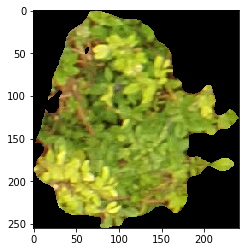

(255, 241, 3)


In [16]:
def display_images(file):
  image = plt.imread(file, format='tif')
  fig, ax = plt.subplots()
  im = ax.imshow(image)
  plt.show()
  print(image.shape)


file = os.path.join(os.path.join(directory,classes[0]),broadleaf[random.randint(0,5)])
display_images(file)

In [0]:
num2class = {0: 'broadleaf', 
         1: 'grass', 
         2: 'soil', 
         3: 'soybean'}

class2num = {'broadleaf' : 0, 
         'grass' : 1, 
         'soil' : 2, 
         'soybean' : 3}

In [0]:

m = 1
num_file = 1100 * m
num_train = 1000 * m  
num_val = 50 * m
num_test = 50 * m

all_files = [] 
num_data =num_file*len(classes)
Y = np.zeros(num_data)


for i, cls in enumerate(classes):
    all_files += [f for f in glob.glob(data_dir+cls+'/*.tif')][:num_file]
    Y[i*num_file:(i+1)*num_file] = i # label all classes with int [0.. len(classes)]

In [0]:

# Image dimension
im_width = 200
im_height = 200 
im_channel = 3
dim = im_width * im_height * im_channel

X = np.ndarray(shape=(num_data, im_width, im_height, im_channel), dtype=np.float64)

for idx, file in enumerate(all_files):
    X[idx] = cv2.resize(cv2.imread(file), (im_width, im_height))

X_train = np.empty(shape=(num_train*len(classes),im_width, im_height, im_channel), dtype=np.float64)
X_val = np.empty(shape=(num_val*len(classes),im_width, im_height, im_channel), dtype=np.float64)
X_test = np.empty(shape=(num_test*len(classes),im_width, im_height, im_channel), dtype=np.float64)

y_train = np.empty(num_train*len(classes))
y_val = np.empty(num_val*len(classes))
y_test = np.empty(num_test*len(classes)) 

for i, cls in enumerate(classes): 
    X_test[num_test*i:num_test*(i+1)] = X[np.where(Y == i)[0][:num_test]]
    X_val[num_val*i:num_val*(i+1)] = X[np.where(Y == i)[0][num_test:num_test+num_val]]
    X_train[num_train*i:num_train*(i+1)] = X[np.where(Y == i)[0][num_test+num_val:]]
    
    y_test[num_test*i:num_test*(i+1)] = i
    y_val[num_val*i:num_val*(i+1)] = i
    y_train[num_train*i:num_train*(i+1)] = i

del Y 
del X

In [21]:
X_train.shape

(4000, 200, 200, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


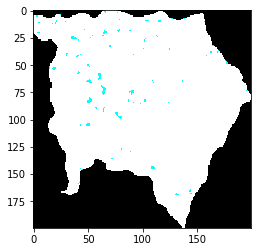

In [22]:
plt.imshow(X_train[500])

In [23]:

# Extract features 
#Shuffle training index
train_idxs = np.random.permutation(X_train.shape[0])
y_train  = y_train[train_idxs].astype(int)
X_train = X_train[train_idxs]

X_train = np.reshape(X_train, (X_train.shape[0], -1)).astype('float64')
X_test = np.reshape(X_test, (X_test.shape[0], -1)).astype('float64')
X_val = np.reshape(X_val, (X_val.shape[0], -1)).astype('float64')

X_tiny = X_train[100:110].astype('float64')
y_tiny = y_train[100:110].astype(int)
num_dev = 500

X_dev = X_train[0:num_dev].astype('float64')
y_dev = y_train[0:num_dev].astype(int)
print("X_train shape", X_train.shape, "| y_train shape:", y_train.shape)
print("X_test shape", X_test.shape, "| y_test shape:", y_test.shape)
print("X_val shape", X_val.shape, "| y_val shape:", y_val.shape)
print("X_dev shape", X_dev.shape, "| y_dev shape:", y_dev.shape)
print("X_tiny shape", X_tiny.shape, "| y_tiny shape:", y_tiny.shape)

#Subtract out the mean image 
#first: compute the mean image
mean_image = np.mean(X_train, axis=0) #axis=0. stack horizontally
#mean_image = 128
#mean_image = 0
#Second subtract the mean image from train and test data 
X_train -= mean_image
X_val -= mean_image 
X_test -= mean_image
X_dev -= mean_image
X_tiny -= mean_image

#Third append the bias dimension using linear algebra trick
#Not for net
# X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
# X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
# X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
# X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])
# X_tiny = np.hstack([X_tiny, np.ones((X_tiny.shape[0], 1))])

print('=====STACK BIAS term=====')
print("X_train shape", X_train.shape)
print("X_test shape", X_test.shape)
print("X_val shape", X_val.shape)
print("X_dev shape", X_dev.shape)
print("X_tiny shape", X_tiny.shape)

X_train shape (4000, 120000) | y_train shape: (4000,)
X_test shape (200, 120000) | y_test shape: (200,)
X_val shape (200, 120000) | y_val shape: (200,)
X_dev shape (500, 120000) | y_dev shape: (500,)
X_tiny shape (10, 120000) | y_tiny shape: (10,)
=====STACK BIAS term=====
X_train shape (4000, 120000)
X_test shape (200, 120000)
X_val shape (200, 120000)
X_dev shape (500, 120000)
X_tiny shape (10, 120000)


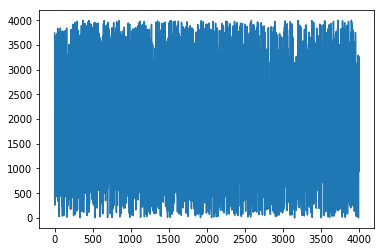

In [24]:

plt.plot(train_idxs)
plt.show()

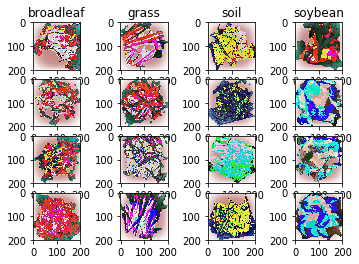

In [27]:
# Visualize some images 
# Make sure that everything when OK
classes = ['broadleaf', 'grass', 'soil', 'soybean']
n_class = len(classes)
samples_per_class = 4

# show some train images
for y, cls in enumerate(classes):
    idxes = np.flatnonzero(y == y_train)
    idxes = np.random.choice(idxes, samples_per_class, replace = False)
    for i, idx in enumerate(idxes):
        plt_idx = i * n_class + y + 1
        plt.subplot(samples_per_class,n_class, plt_idx)
        plt.imshow(X_train[idx].reshape(im_width, im_height, im_channel).astype('uint8'))
        if(i==0): plt.title(cls)

plt.show()

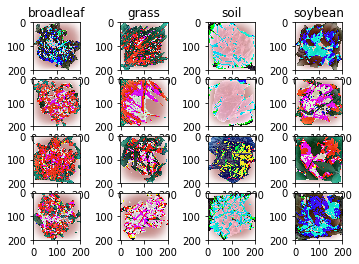

In [28]:
# show some dev images
for y, cls in enumerate(classes):
    idxes = np.flatnonzero(y == y_dev)
    idxes = np.random.choice(idxes, samples_per_class, replace = False)
    for i, idx in enumerate(idxes):
        plt_idx = i * n_class + y + 1
        plt.subplot(samples_per_class,n_class, plt_idx)
        plt.imshow(X_dev[idx].reshape(im_width, im_height, im_channel).astype('uint8'))
        if(i==0): plt.title(cls)

plt.show()

In [0]:
class TwoLayerNet():
    def __init__(self, input_size, hidden_size, output_size, std= 1e-4):
        '''
        std: weight initialization term
        W1: first layer weight, shape(D x H) 
        W2: second layer weight shape(H x C) 
        C: num_classes(output_size) , H: hidden_size, D: data_dim(input_size) 
        '''
        self.params = {}
        self.params['W1'] = std * np.random.randn(input_size, hidden_size)
        self.params['b1'] = np.zeros(hidden_size)
        self.params['W2'] = std * np.random.randn(hidden_size, output_size)
        self.params['b2'] = np.zeros(output_size)
        
    def loss(self, X, y = None, reg=0.0):
        '''
        reg: regularization strength
        X: ndarray shape(N x C). N: num of data 
        y: vector of training label
        '''
        #DEfine relu activation function 
        relu = lambda x:np.maximum(0,x)

        #unpack
        W1, b1 = self.params['W1'], self.params['b1']
        W2, b2 = self.params['W2'], self.params['b2']
        N, D = X.shape

        #Forward prop
        layer1 = relu(X.dot(W1) + b1)  #(N,D) x (D,H) = (N,H)
        scores = layer1.dot(W2) + b2

        #if target is not given then jump out 
        if(y is None): 
            return scores

        #compute the loss 
        ##Normalization trick to prevent overflow when compute exp 
        scores -= scores.max()#stack vertically

        scores = np.exp(scores)
        scores_sumexp = np.sum(scores, axis=1)#stack vertically
        ##Nomalize all score 
        softmax = scores / scores_sumexp.reshape(N,1)  #Shape: (N, C)
        #total loss of all training. -log of all correct score
        loss =  (-1.0) * np.sum(np.log(softmax[range(N),y]))

        ##Normalize the loss and add regularization strength 
        loss /= N 
        loss += reg * np.sum(W1 * W1) 
        loss += reg * np.sum(W2 * W2) 

        #Backward pass on the net 
        grads = {}

        correct_class_scores = scores[range(N), y]
        softmax[range(N), y] = (-1.0) * (scores_sumexp - correct_class_scores)/scores_sumexp
        softmax /= N

        #Want to find dW2(dL/dW2)
        # Derivation: dL/dW2 = dL/dscore * dscore/dW2(chain rule)
        #dL/dscore = softmax since L(score) = softmax(variable)
        #dscore/dW2 = relu_(hidden layer output)
        grads['W2'] = layer1.T.dot(softmax)
        grads['b2'] = np.sum(softmax, axis=0)#stack horizontally
        grads['W2'] += reg * 2 * W2

        #dL/dW1 = dL/dscore * dscore/drelu(layler1) * drelu(layer1)/dW1 
        #dL/dW1 = dW1 = softmax * W2 * X 
        hidden = softmax.dot(W2.T)

        #derivative of a max gate
        #Intuition: in forward pass if neuron didn't fire that mean. the derivative of that neuron 
        # is 0. This might be bad since this will kill gradient. 
        hidden[layer1 == 0] = 0 

        grads['W1'] = X.T.dot(hidden) 
        grads['b1'] = np.sum(hidden, axis=0) #stack horizontally 
        grads['W1'] += reg * 2 * W1

        return loss, grads

    def train(self, X, y, X_val, y_val, 
              learning_rate =1e-3, learning_rate_decay=0.95, 
              reg=5e-6, num_iters=100, 
              batch_size=200, it_verbose = 1, verbose=False):
        '''
        Train using SGD 
        Input: 
            X: nd array shape(N x D) 
            y: vector of train label 
            X_val: nd array shape( n_VAL , D) Use as validation set after each epoch 
            y_val: vector of validation label 
        '''
        N, D = X.shape
        N_val = X_val.shape[0]
        iteration_per_epoch = max(N/batch_size, 1)
        
        loss_hist = []
        train_acc_hist = []
        val_acc_hist = []
        
        for it in range(num_iters):
            sampling = np.random.choice(np.arange(N), batch_size, replace=False) 
            X_batch = X[sampling]
            y_batch = y[sampling]
            
            #compute loss and gradients
            loss, grads = self.loss(X_batch, y=y_batch, reg=reg)
            loss_hist.append(loss) 
            
            #Update rule 
            self.params['W1'] += (-1.0) * learning_rate * grads['W1']
            self.params['b1'] += (-1.0) * learning_rate * grads['b1']
            self.params['W2'] += (-1.0) * learning_rate * grads['W2']
            self.params['b2'] += (-1.0) * learning_rate * grads['b2']
            
            if(verbose and it%it_verbose==0):
                print('iteration: %d / %d | Loss: %f' % (it, num_iters, loss)) 
            # Every epoch, check train and val accuracy and decay learning rate.
            if (it % iteration_per_epoch == 0):
                # Check accuracy
                train_acc = (self.predict(X_batch) == y_batch).mean()
                val_acc = (self.predict(X_val) == y_val).mean()
                train_acc_hist.append(train_acc)
                val_acc_hist.append(val_acc)

                 # Decay learning rate
                learning_rate *= learning_rate_decay
        return {
            'loss_hist':loss_hist,
            'train_acc_hist':train_acc_hist,
            'val_acc_hist':val_acc_hist
        }

    def predict(self, X):
        """
        Use the trained weights of this two-layer network to predict labels for
        data points. For each data point we predict scores for each of the C
        classes, and assign each data point to the class with the highest score.

        Inputs:
        - X: A numpy array of shape (N, D) giving N D-dimensional data points to
        classify.

        Returns:
        - y_pred: A numpy array of shape (N,) giving predicted labels for each of
        the elements of X. For all i, y_pred[i] = c means that X[i] is predicted
        to have class c, where 0 <= c < C.
        """
        y_pred = None
        relu = lambda x:np.maximum(0,x)
        # Unpack variables from the params dictionary
        W1, b1 = self.params['W1'], self.params['b1']
        W2, b2 = self.params['W2'], self.params['b2']

#Forward propagation though the network 
        layer1 = relu(X.dot(W1) + b1)
        scores = layer1.dot(W2) + b2 #shape: (N x C)
        y_pred = np.argmax(scores, axis=1)

        return y_pred

        


In [30]:

input_size = im_width * im_height * im_channel
hidden_size = 200
output_size = n_class 
std = 1e-3 # size initialization parameter

net = TwoLayerNet(input_size, hidden_size,output_size,std )
#stats = net.train(X_dev, y_dev, X_val, y_val, 
#              learning_rate =1e-5, learning_rate_decay=0.95, 
#              reg=0.0, num_iters=140, 
#              batch_size=100, it_verbose = 10,verbose=True)
stats = net.train(X_train, y_train, X_val, y_val, 
              learning_rate =1e-5, learning_rate_decay=0.95, 
              reg=0.0, num_iters=300, 
              batch_size=100, it_verbose = 10,verbose=True)

iteration: 0 / 300 | Loss: 1.427937
iteration: 10 / 300 | Loss: 1.352580
iteration: 20 / 300 | Loss: 1.304629
iteration: 30 / 300 | Loss: 1.303307
iteration: 40 / 300 | Loss: 1.207999
iteration: 50 / 300 | Loss: 1.233997
iteration: 60 / 300 | Loss: 1.159693
iteration: 70 / 300 | Loss: 1.147994
iteration: 80 / 300 | Loss: 1.134495
iteration: 90 / 300 | Loss: 1.117425
iteration: 100 / 300 | Loss: 1.071140
iteration: 110 / 300 | Loss: 1.073509
iteration: 120 / 300 | Loss: 1.021453
iteration: 130 / 300 | Loss: 1.015465
iteration: 140 / 300 | Loss: 0.984723
iteration: 150 / 300 | Loss: 0.945795
iteration: 160 / 300 | Loss: 0.923800
iteration: 170 / 300 | Loss: 0.987150
iteration: 180 / 300 | Loss: 0.851708
iteration: 190 / 300 | Loss: 0.906308
iteration: 200 / 300 | Loss: 0.850541
iteration: 210 / 300 | Loss: 0.909477
iteration: 220 / 300 | Loss: 0.968522
iteration: 230 / 300 | Loss: 0.851818
iteration: 240 / 300 | Loss: 0.894184
iteration: 250 / 300 | Loss: 0.864828
iteration: 260 / 300 | 

In [33]:
print((net.predict(X_val) == y_val).mean())

0.675


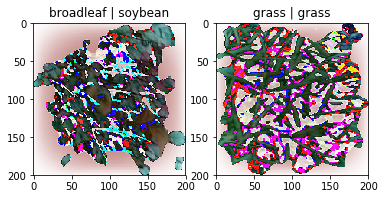

In [41]:
index = np.flatnonzero(0 == y_train)
index = np.random.choice(index, 1, replace=False)
prediction = net.predict(X_train[index])

plt.subplot(1, 2, 1)
plt.title('{} | {}'.format(classes[0], classes[prediction[0]]))
plt.imshow(X_train[index].reshape(200, 200, 3).astype('uint8'))

index = np.flatnonzero(1 == y_train)
index = np.random.choice(index, 1, replace=False)
prediction = net.predict(X_train[index])

plt.subplot(1, 2, 2)
plt.title('{} | {}'.format(classes[1], classes[prediction[0]]))
plt.imshow(X_train[index].reshape(200, 200, 3).astype('uint8'))